<div style="text-align:center">
    <h1>
        Deep SARSA
    </h1>
</div>

<br><br>

<div style="text-align:center">

In this notebook, we extend the SARSA algorithm to use function approximators (Neural Networks). The resulting algorithm is known as Deep SARSA.
</div>

<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 8 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import numpy as np
import random
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm # for progress bar
from utils import plot_cost_to_go, plot_max_q, test_agent, plot_stats, seed_everything

%matplotlib inline

## Create and prepare the environment

### Create the environment

In [2]:
env = gym.make('MountainCar-v0')
seed_everything(env) #make sure all the random numbers are the same

In [3]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f'Mountain car as {state_dims} state dimensions, and {num_actions} actions to choose.')

Mountain car as 2 state dimensions, and 3 actions to choose.


### Prepare the environment to work with PyTorch

In [4]:
from gym.core import Env


class PreprocessEnv(gym.Wrapper):
    def __init__(self, env: Env) -> None:
        super().__init__(env)

    # override reset
    def reset(self):
        state = self.env.reset()
        
        # convert numpy array to tensor
        t = torch.from_numpy(state)
        return t.unsqueeze(dim=0).float() 

    # override step
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = 1 if done else 0
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [5]:
env = PreprocessEnv(env)

In [6]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(next_state)
print(reward)
print(done)

tensor([[-0.5262, -0.0010]])
tensor([[-1.]])
tensor([[0]])


## Create the Q-Network and policy

<br><br>

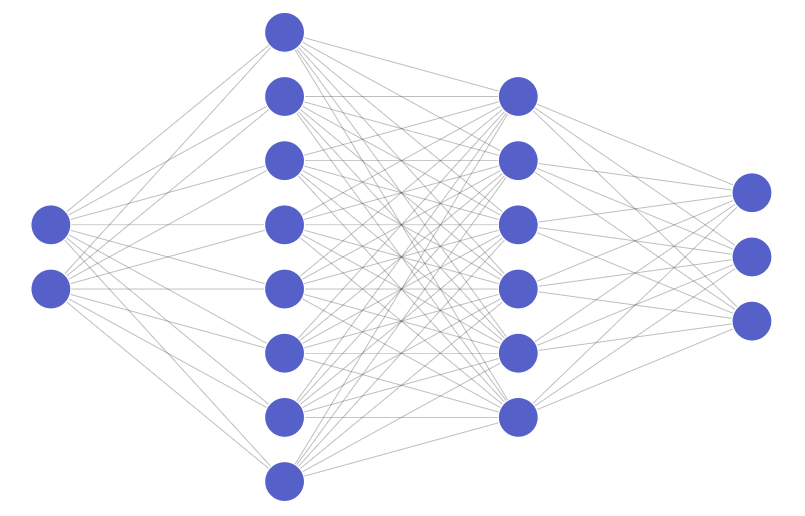

### Create the Q-Network: $\hat q(s,a| \theta)$

In [7]:
q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions),
)

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

In [8]:
target_q_network = copy.deepcopy(q_network).eval() # freeze the weights
target_q_network

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [9]:
def policy(state, epsilon=0.):    
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)


### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

/home/weiminn/Documents/reinforcement/venv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


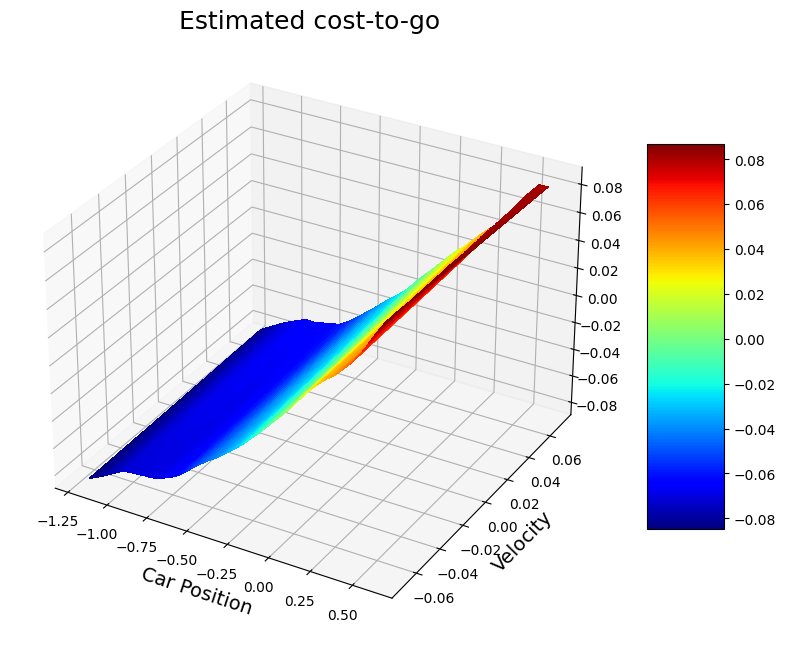

In [10]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

## Create the Experience Replay buffer

<br>
<div style="text-align:center">
    <p>A simple buffer that stores transitions of arbitrary values, adapted from
    <a href="https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training">this source.</a></p>
</div>

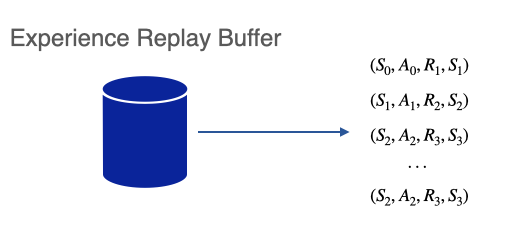


In [11]:
class ReplayMemory:
    def __init__(self, capacity=1000000) -> None:
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position +1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        # [(s,a,r,s'), (s,a,r,s'), (s,a,r,s'), ...]
        batch = random.sample(self.memory, batch_size)

        # [[s,s,s,..], [a,a,a,...], [r,r,r,...], [s',s',s',...]]
        batch = zip(*batch)

        #
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10
    
    def __len__(self):
        return len(self.memory)
    

## Implement the algorithm

</br></br>

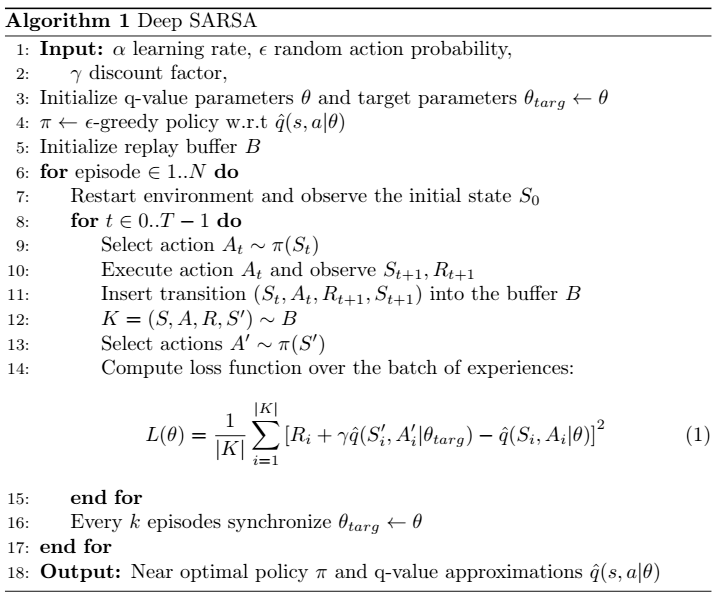

In [12]:
def deep_sarsa(q_network, policy, episodes, alpha=.001, batch_size=32, gamma=.99, epsilon=.01):

    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': []}

    for episode in tqdm(range(1, episodes+1)):
        state = env.reset()
        done = False
        ep_return = 0.

        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.insert([state, action, reward, done, next_state])

            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                
                qsa = q_network(state_b).gather(1, action_b)

                next_action_b = policy(next_state_b, epsilon)
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b)
                bootstrapped = reward_b + (1-done_b) * gamma * next_qsa_b

                loss = F.mse_loss(qsa, bootstrapped)
                q_network.zero_grad()
                loss.backward()
                optim.step()

                stats['MSE Loss'].append(loss.item())

            state = next_state
            ep_return += reward.item()
        
        stats['Returns'].append(ep_return)

        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())
    
    return stats

In [13]:
stats = deep_sarsa(q_network, policy, 1500)

100%|██████████| 1500/1500 [19:56<00:00,  1.25it/s]


## Show results

### Plot execution stats

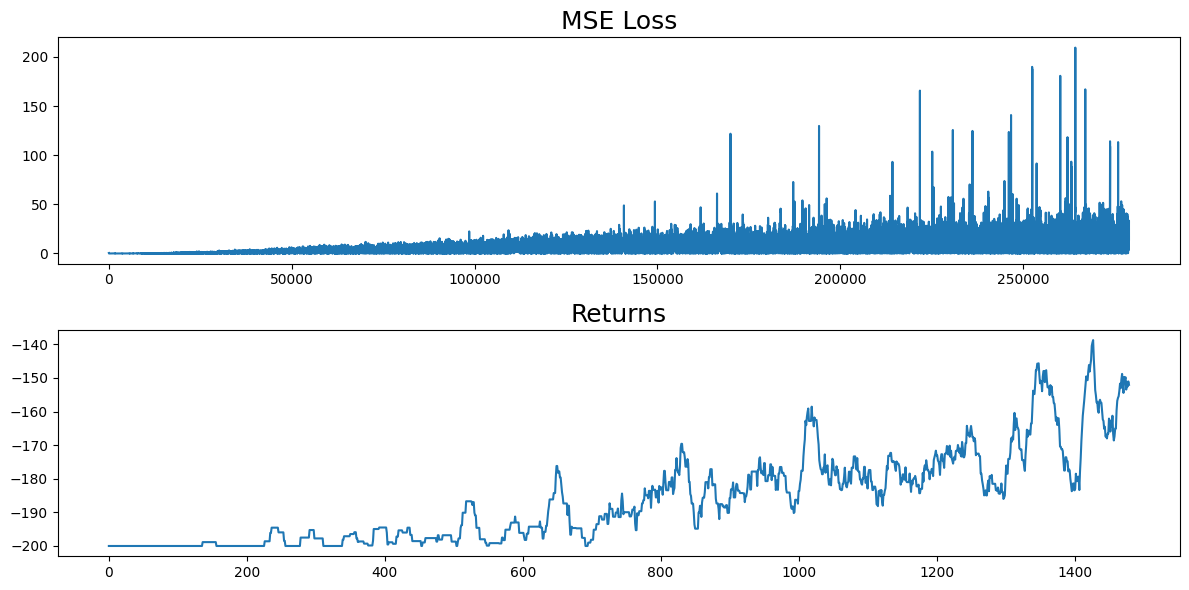

In [14]:
plot_stats(stats)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

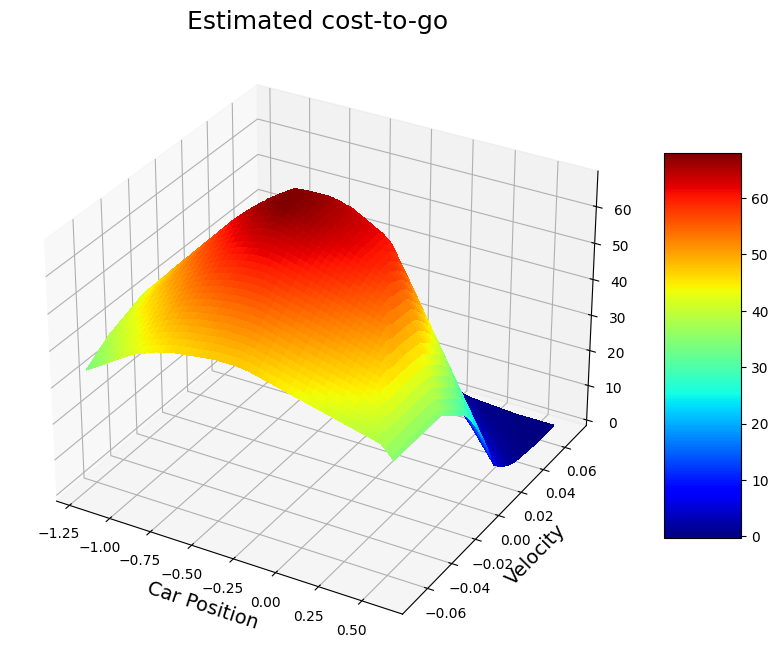

In [15]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

### Show resulting policy: $\pi(s)$

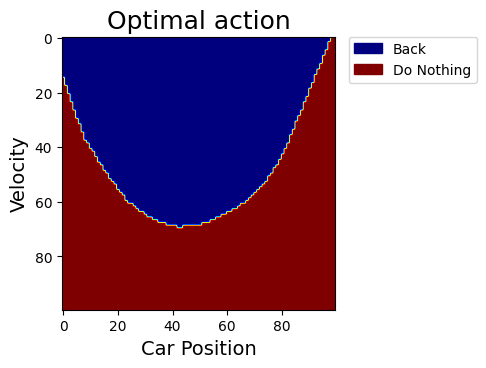

In [16]:
plot_max_q(env, q_network, xlabel='Car Position', ylabel='Velocity', action_labels=['Back', 'Do Nothing', 'Forward'])

### Test the resulting agent

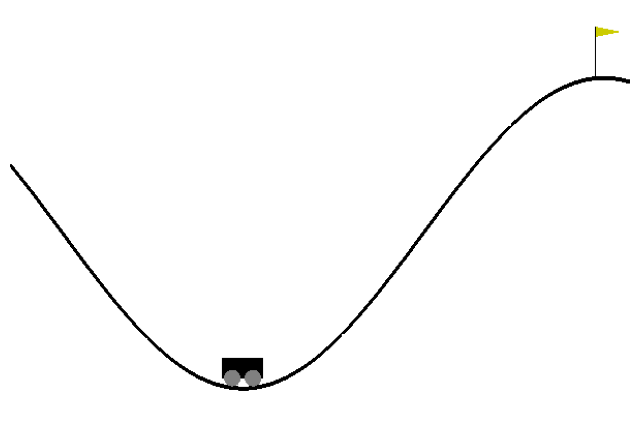

In [18]:
%matplotlib inline
test_agent(env, policy, episodes=2)

## Resources

[[1] Deep Reinforcement Learning with Experience Replay Based on SARSA](https://www.researchgate.net/publication/313803199_Deep_reinforcement_learning_with_experience_replay_based_on_SARSA)